In [1]:
!pip install yfinance
!pip install matplotlib pydot

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


In [3]:
# Set the stock ticker symbol
ticker = 'TM'

# Fetch data from Yahoo Finance
data = yf.download(ticker, start="2020-12-01", end="2023-12-01")


[*********************100%%**********************]  1 of 1 completed


In [4]:
# Display the first few rows of the dataset
print(data.head())

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2020-12-01  135.600006  136.460007  135.179993  136.139999  136.139999  289200
2020-12-02  136.050003  136.710007  135.770004  136.339996  136.339996  197900
2020-12-03  137.770004  138.160004  136.750000  136.850006  136.850006  171500
2020-12-04  137.899994  138.850006  137.750000  138.279999  138.279999  137800
2020-12-07  138.600006  138.820007  137.699997  138.149994  138.149994  150100


In [5]:
# Extract the 'Close' prices from the DataFrame
df2 = data.reset_index()['Close']
print(df2)

0      136.139999
1      136.339996
2      136.850006
3      138.279999
4      138.149994
          ...    
750    188.300003
751    186.610001
752    187.160004
753    189.509995
754    189.779999
Name: Close, Length: 755, dtype: float64


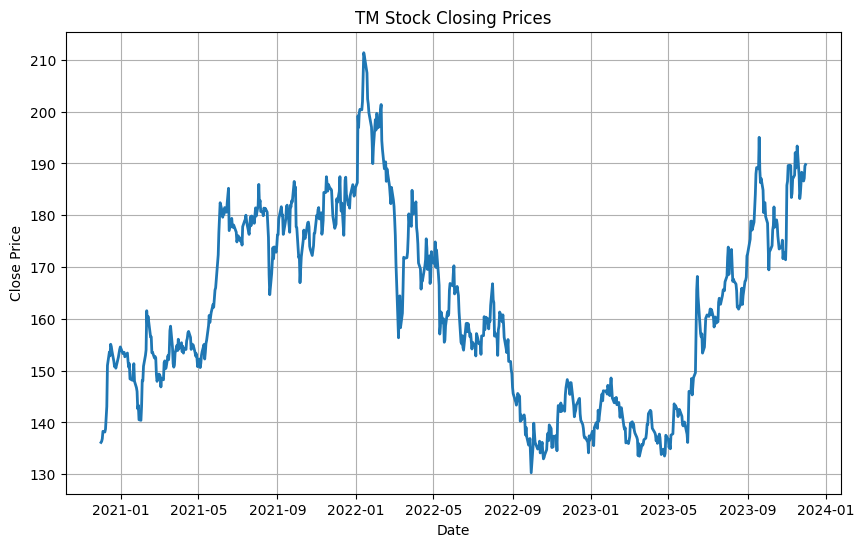

In [6]:
# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(data.index, df2,lw=2)
plt.grid()
plt.title(f'{ticker} Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [7]:
# Scale the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df2_scaled = scaler.fit_transform(np.array(df2).reshape(-1, 1))
print(df2_scaled[:10])

[[0.07215104]
 [0.0746177 ]
 [0.0809079 ]
 [0.09854471]
 [0.0969413 ]
 [0.1042182 ]
 [0.13061188]
 [0.15762227]
 [0.25542682]
 [0.28724726]]


In [8]:
# Define the time window for the LSTM model
time_window = 50

# Create lists to store the features and labels
X, y = [], []

# Populate the lists
for i in range(len(df2_scaled) - time_window):
    X.append(df2_scaled[i:i+time_window, 0])
    y.append(df2_scaled[i+time_window, 0])

# Convert the lists to NumPy arrays
X, y = np.array(X), np.array(y)

# Reshape the data to be 3-dimensional for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(time_window, 1)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(LSTM(units=100))
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Display the model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 131501 (513.68 KB)
Trainable params: 131501 (513.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Create a generator function for training data
def generate_sequences(X, y, batch_size):
    while True:
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            yield X_batch, y_batch

# Assuming X_train and y_train are your training data
batch_size = 32
train_generator = generate_sequences(X_train, y_train, batch_size)

In [13]:
# Fit the model to the training data
epochs = 10
lstm_model.fit(train_generator, epochs=epochs, steps_per_epoch=len(X_train)//batch_size)


Epoch 1/10
17/17 [==============================] - 8s 101ms/step - loss: 0.0397
Epoch 2/10
17/17 [==============================] - 2s 101ms/step - loss: 0.0094
Epoch 3/10
17/17 [==============================] - 2s 99ms/step - loss: 0.0073
Epoch 4/10
17/17 [==============================] - 2s 99ms/step - loss: 0.0063
Epoch 5/10
17/17 [==============================] - 2s 98ms/step - loss: 0.0057
Epoch 6/10
17/17 [==============================] - 2s 149ms/step - loss: 0.0051
Epoch 7/10
17/17 [==============================] - 2s 132ms/step - loss: 0.0051
Epoch 8/10
17/17 [==============================] - 2s 100ms/step - loss: 0.0050
Epoch 9/10
17/17 [==============================] - 2s 98ms/step - loss: 0.0045
Epoch 10/10
17/17 [==============================] - 2s 102ms/step - loss: 0.0043


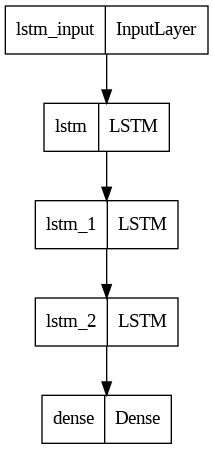

In [14]:
# Plot the model architecture
plot_model(lstm_model)

In [15]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Set up a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr  # Keep the initial learning rate for the first 5 epochs
    else:
        return lr * 0.9


In [16]:
# Train the model with callbacks
history = lstm_model.fit(train_generator, epochs=epochs, steps_per_epoch=len(X_train)//batch_size,
                         validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/10
17/17 [==============================] - 4s 269ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 2/10
17/17 [==============================] - 4s 210ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/10
17/17 [==============================] - 2s 122ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/10
17/17 [==============================] - 2s 122ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 5/10
17/17 [==============================] - 2s 108ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 6/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 8/10
17/17 [==============================] - 3s 161ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 9/10
17/17 [==============================] - 2s 142ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/10
17/17 [==============================] - 2s 109ms/step - loss: 0.0025 - val_loss: 0.0034

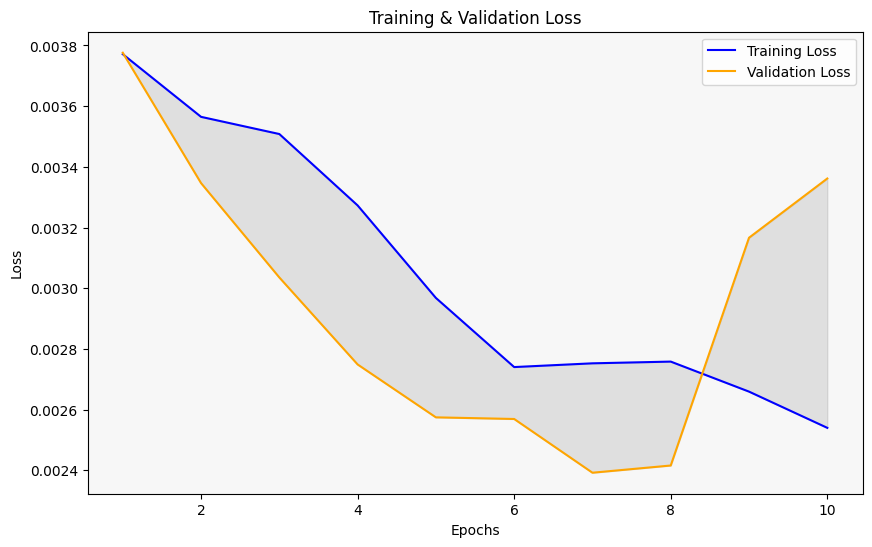

In [17]:
# Assuming you have the 'history' object from model training
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 6))
# Plot training loss
plt.plot(epochs, history.history['loss'], color='blue', label='Training Loss')

# Plot validation loss
plt.plot(epochs, history.history['val_loss'], color='orange', label='Validation Loss')

# Fill the area between the lines
plt.fill_between(epochs, history.history['loss'], history.history['val_loss'], color='gray', alpha=0.2)

# Add background color
ax = plt.gca()
ax.set_facecolor('#f7f7f7')

# Add labels and title
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [18]:
# Predicting on the test data
y_pred_scaled = lstm_model.predict(X_test)

# Invert predictions to the original scale
y_pred = scaler.inverse_transform(y_pred_scaled)

# Invert actual values to the original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 [==============================] - 1s 32ms/step


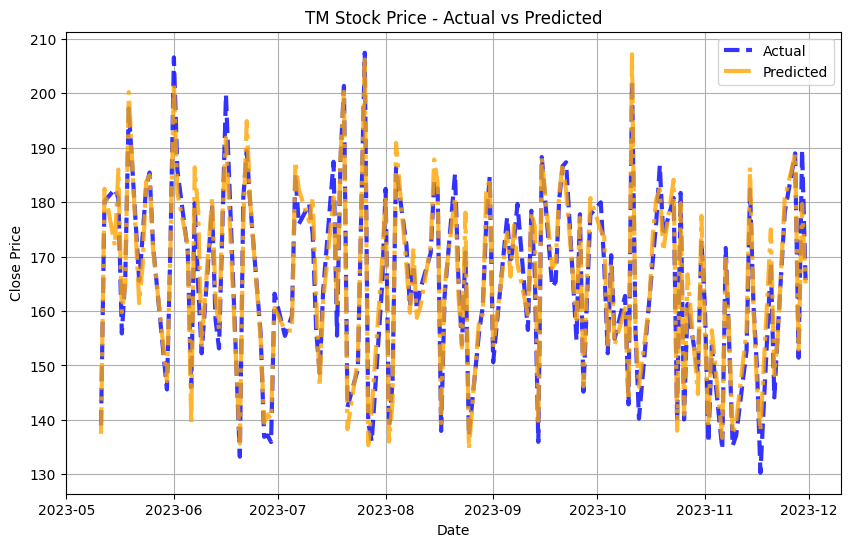

In [19]:
# Assuming 'data', 'y_test_original', and 'y_pred' are available
# Plot actual and predicted values in one plot
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(data.index[-len(y_test_original):], y_test_original, 'b--',label='Actual', lw=3, alpha=0.8)

# Plot predicted values
plt.plot(data.index[-len(y_test_original):], y_pred, "-.",color = 'orange', label='Predicted', lw=3, alpha=0.8)

# Add labels and title
plt.title(f'{ticker} Stock Price - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
# Show the plot
plt.show()



In [20]:
# Calculating RMSE of the model
RMSE = np.sqrt(((y_test_original.reshape(-1)-y_pred.reshape(-1))**2).sum(axis=0))

print('RMSE of the model: ', RMSE)

RMSE of the model:  47.09037644821899


In [21]:
def predict_future_days(model, base_data, days_to_predict, scaler, time_window=60):
    # Check if base_data has enough elements
    if len(base_data[0]) < time_window:
        raise ValueError("Not enough data points in base_data to create a window of size time_window.")

    # Start with the last days of the base data
    input_data = base_data[:, -time_window:, :]  # Keep the shape consistent

    # Predict future days
    predictions = []
    for _ in range(days_to_predict):
        # Predict the next day
        next_day_scaled = model.predict(input_data)
        predictions.append(next_day_scaled[-1, 0])  # Adjust indexing

        # Update the input_data for the next prediction
        input_data = np.roll(input_data, -1, axis=1)  # Shift the data one step to the left
        input_data[0, -1, 0] = next_day_scaled[-1, 0]  # Replace the last element with the predicted value

    # Inverse transform the predictions to get the original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions

In [22]:
# Assuming 'scaled_data' is your scaled historical data
scaled_data = scaler.transform(np.array(df2).reshape(-1, 1))

# Reshape the data for univariate time series (single feature)
scaled_data = scaled_data.reshape(1, -1, 1)  # Assuming batch_size=1, time_steps is the length of your data, and features=1

# Predict next 50 days
days_to_predict = 50
future_days = predict_future_days(lstm_model, scaled_data, days_to_predict, scaler, time_window)

1/1 [==============================] - 0s 37ms/step


<ipython-input-23-116872d59906>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')


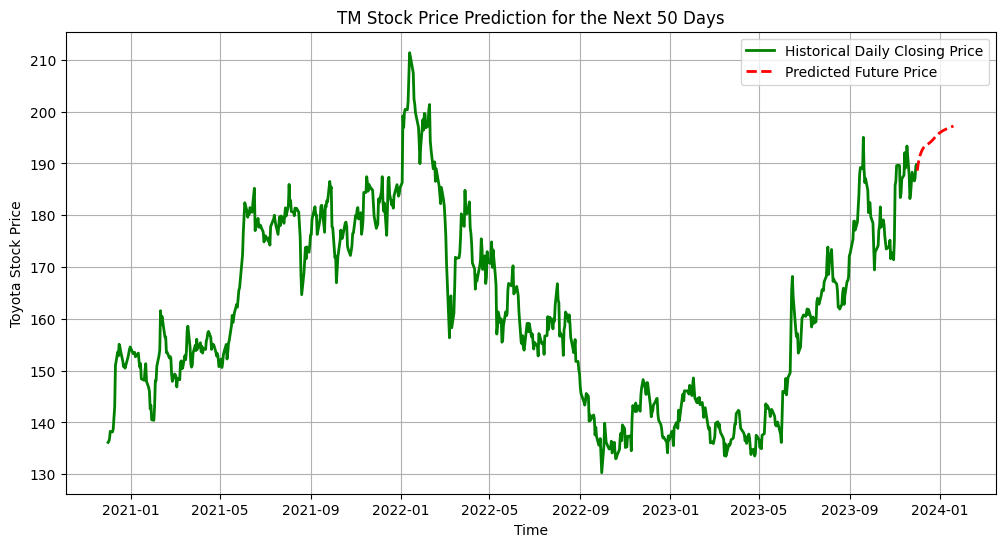

In [23]:
# Plot the predictions
predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], lw=2, color='green', label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days, '--',lw=2, color='red', label='Predicted Future Price')
plt.title(f'{ticker} Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('Toyota Stock Price')
plt.legend()
plt.grid()
plt.show()